# Bengalese finch

Requires _DAS_ to be installed. See [documentation](https://janclemenslab.org/das/installation.html) for instructions.

Sample data from:   
Nicholson D, Queen JE, J. Sober S. 2017.   
Bengalese finch song repository.   
doi:10.6084/m9.figshare.4805749.v5   
Original data deposited at [https://figshare.com/articles/dataset/Bengalese_Finch_song_repository/4805749]().

In [1]:
import numpy as np
from pprint import pprint
import das.predict, das.evaluate, das.utils_plot, das.menagerie
import matplotlib.pyplot as plt
import librosa.feature
import warnings


plt.style.use('../ncb.mplstyle')
warnings.filterwarnings("ignore")

## Load example data

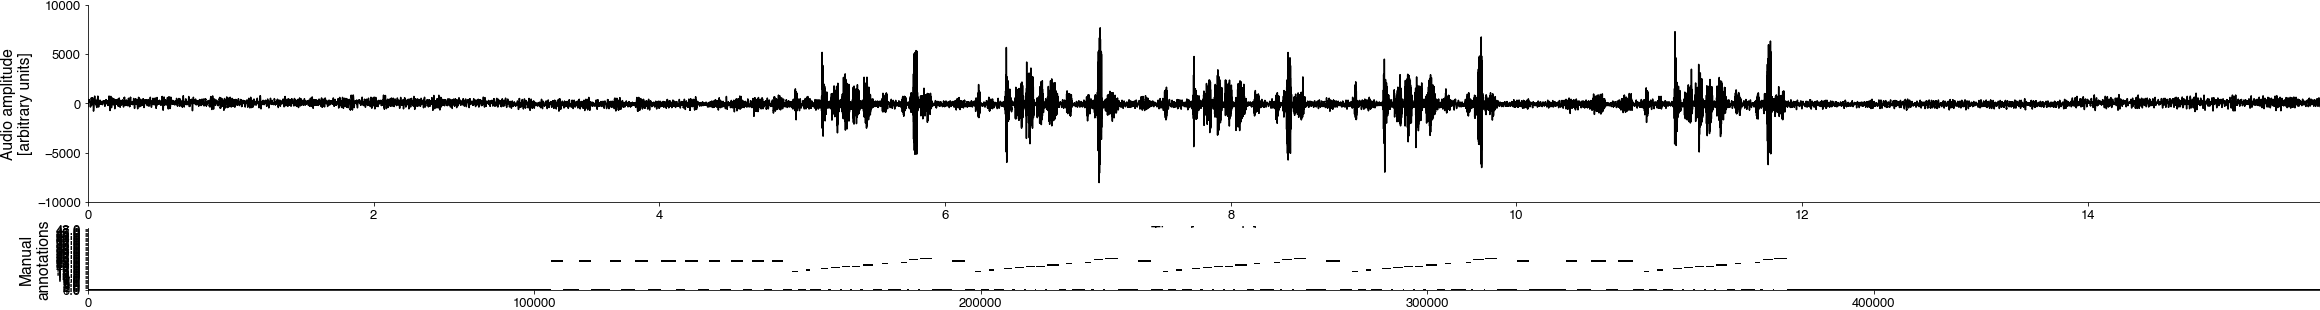

In [2]:
url = "https://github.com/janclemenslab/das-menagerie/releases/download/bengalese_finch_v1.0/data.npz"
data = das.menagerie.load_data(url)
data['x'] = data['x'][400_000:900_000]
data['y_true'] = data['y_true'][400_000:900_000]

samplerate_Hz = data['samplerate_Hz']
T = np.arange(len(data['x'])) / samplerate_Hz

plt.figure(figsize=(40, 8))
plt.subplot(211)
# plt.plot(data['x'][::10], c='k')
plt.plot(T[::10], data['x'][::10], c='k')
plt.xlim(T[0], T[-1])
plt.xlabel('Time [seconds]')
plt.ylabel('Audio amplitude\n[arbitrary units]')

plt.subplot(614)
plt.imshow(data['y_true'].T, cmap='Greys')
plt.yticks(np.arange(len(data['class_names'])), labels=data['class_names'])
plt.ylabel('Manual\nannotations')
plt.show()

## Generate annotations using _DAS_

In [3]:
events, segments, class_probabilities, class_names = das.predict.predict(data['x'], "https://github.com/janclemenslab/das-menagerie/releases/download/bengalese_finch_v1.0/fourmales",
                                                           segment_thres=0.5,
                                                           segment_minlen=0.005,
                                                           segment_fillgap=0.005)

## Plot annotations from groundtruth and _DAS_

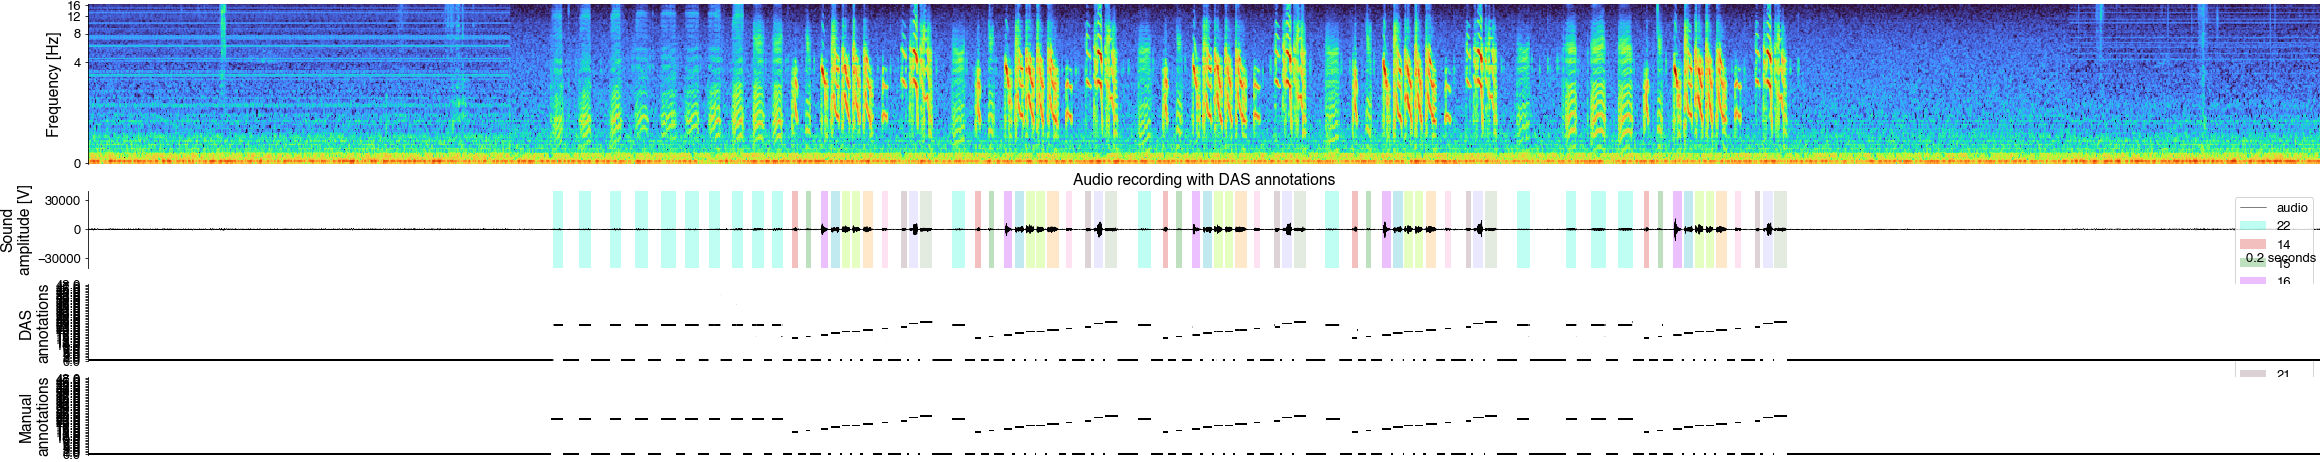

In [4]:
i0 = int(0 * samplerate_Hz)
i1 = int(len(data['x']))# * samplerate_Hz)
T = np.arange(i0, i1) / samplerate_Hz

specgram = librosa.feature.melspectrogram(data['x'][i0:i1, 0], sr=samplerate_Hz, n_fft=512 + 256, hop_length=100, power=1)
specgram = librosa.amplitude_to_db(specgram, ref=np.max(specgram))
freqs = np.round(librosa.mel_frequencies(n_mels=128, fmin=0.0, fmax=samplerate_Hz/2, htk=False)/10) * 10

freq_ticks = np.where(np.mod(freqs, 4_000)<=500)[0]
freq_labels, idx = np.unique(np.round(freqs[freq_ticks]/1_000)*1_000, return_index=True)
freq_labels = (freq_labels / 1_000).astype(np.int)  # to kHz
freq_ticks = freq_ticks[idx]

plt.figure(figsize=(40, 10))
plt.subplot(311)
plt.imshow(specgram, cmap='turbo')
plt.yticks(freq_ticks, labels=freq_labels)
plt.ylabel('Frequency [Hz]')
das.utils_plot.despine(which='tbr')

plt.subplot(613)
plt.plot(T, data['x'][i0:i1], c='k', linewidth=0.5, label='audio')
das.utils_plot.annotate_segments(onset_seconds=segments['onsets_seconds'], offset_seconds=segments['offsets_seconds'], 
                  segment_names=[segments['names'][ii] for ii in segments['sequence']], 
                  tmin=T[0], tmax=T[-1])
plt.xlim(T[0], T[-1])
plt.ylim(-4.0e4, 4.0e4)
plt.yticks(np.arange(-3e4, 3.1e4, 3e4))
plt.legend(loc='upper right', frameon=True, facecolor='w')
plt.ylabel('Sound\namplitude [V]')
plt.title('Audio recording with DAS annotations')
das.utils_plot.despine(which='tbr')
das.utils_plot.scalebar(length=0.2, units='seconds')

plt.subplot(614)
plt.imshow(segments['probabilities'][i0:i1, :].T, cmap='Greys')
plt.yticks(np.arange(len(data['class_names'])), labels=data['class_names'])
plt.ylabel('DAS\nannotations')
das.utils_plot.despine(which='tbr')

plt.subplot(615)
plt.imshow(data['y_true'][i0:i1].T, cmap='Greys')
plt.yticks(np.arange(len(data['class_names'])), labels=data['class_names'])
plt.ylabel('Manual\nannotations')
das.utils_plot.despine(which='tbr')
plt.show()

## Evaluate sample-wise annotation performance

Confusion matrix (sample-wise)
         true 0  true 14  true 15  true 16  true 17  true 18  true 19  \
pred 0    10949        3        4        1        2        3        2   
pred 14       1      193        0        0        0        0        0   
pred 15       5        0      182        0        0        0        0   
pred 16       1        0        0      278        0        0        0   
pred 17       3        0        0        0      318        0        0   
pred 18       6        0        0        0        0      583        0   
pred 19       5        0        0        0        0        0      377   
pred 20       2        0        0        0        0        0        0   
pred 21       3        0        0        0        0        0        0   
pred 22      31        0        0        0        0        0        0   
pred 23       5        0        0        0        0        0        0   
pred 24       3        0        0        0        0        0        0   

         true 20  t

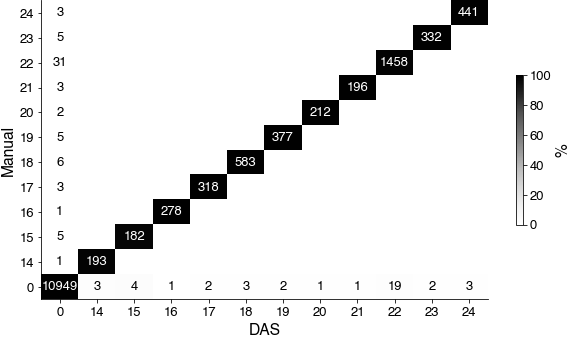

In [7]:
# evaluate performance for individual call tyes
min_len = min(data['y_true'].shape[0], segments['samples'].shape[0])
labels_true = np.argmax(data['y_true'][:min_len], axis=1)
labels_pred = segments['samples'][:min_len]
# labels_pred = np.argmax(segments['probabilities'][:min_len], axis=1)
step = int(samplerate_Hz / 1_000)


class_names = [str(c) for c in np.unique(labels_true)]
confmat, report = das.evaluate.evaluate_segments(labels_true[::step], labels_pred[::step], class_names, confmat_as_pandas=True, report_as_dict=False)

confmat_norm = confmat / np.sum(confmat, axis=0) * 100
nb_classes = len(class_names)

print('Confusion matrix (sample-wise)')
print(confmat)

plt.figure(figsize=(10, 5.5))
plt.imshow(confmat_norm, cmap='Greys')
plt.clim(0, 100)
plt.xticks(np.arange(nb_classes), labels=class_names)
plt.yticks(np.arange(nb_classes), labels=class_names)
plt.xlabel('DAS')
plt.ylabel('Manual')
plt.colorbar(shrink=0.5, label='%')
das.utils_plot.imshow_text(confmat_norm.values, confmat.values)

## Evaluate the temporal precision of syllable on- and offsets
True/false positives/negatives are determined based on a distance threshold: Any detected on- or offset with a true on- or offset within the tolerance counts as a true positive. The precision, recall, and F1-score are calculated accordingly.

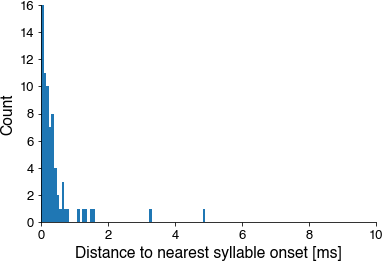

Temporal precision of syllable onsets
{'FN': 1,
 'FP': 1,
 'TP': 71,
 'f1_score': 0.9861111111111112,
 'median_error_ms': 0.21875,
 'precision': 0.9861111111111112,
 'recall': 0.9861111111111112}


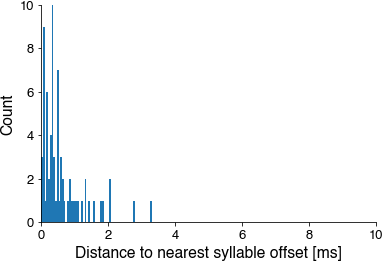

Temporal precision of syllable offsets
{'FN': 0,
 'FP': 0,
 'TP': 72,
 'f1_score': 1.0,
 'median_error_ms': 0.375,
 'precision': 1.0,
 'recall': 1.0}


In [8]:
# detect syllable on- and offsets in the groundtruth data ("true") and the DAS predictions ("pred")
onsets_true, offsets_true = das.evaluate.segment_timing((labels_true>0).astype(np.float), samplerate_Hz)
onsets_pred, offsets_pred = das.evaluate.segment_timing((labels_pred>0).astype(np.float), samplerate_Hz)

# match on- and offsets with tolerance `tol`
tol = 0.01  # s
for true, pred, name in zip([onsets_true, offsets_true], [onsets_pred, offsets_pred], ['onset', 'offset']):

    report_timing,  _, _, dist_to_nearest = das.event_utils.evaluate_eventtimes(true, pred, samplerate_Hz, tol)
    report_timing['median_error_ms'] = np.median(dist_to_nearest[dist_to_nearest < tol]) * 1_000  # ms
    plt.hist(dist_to_nearest[dist_to_nearest < tol] * 1000, bins=64)
    plt.xlabel(f'Distance to nearest syllable {name} [ms]')
    plt.ylabel('Count')
    plt.xlim(0, tol * 1_000)
    plt.show()
    print(f"Temporal precision of syllable {name}s")
    pprint(report_timing)